# Washington DC Biking data | Hourly Bike Count Prediction
MBD O-1-5

### Notebook preperation

In [116]:
# Imports
%matplotlib inline


from My_Functions import * 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler,PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator , MultipleLocator
##from matplotlib import XAxis
from gplearn.genetic import SymbolicRegressor

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression,LinearRegression, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
import plotly.tools as tls
import plotly
plotly.tools.set_credentials_file(username='Furqan92', api_key='22DfVN5rFRg79OYygN5h')
import plotly.plotly as py
from sklearn.decomposition import PCA
from pandas import DataFrame 
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random_seed = 1234

In [117]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%run My_Functions.py
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# Data Import
hourly_raw_data = pd.read_csv('hour.csv')

# Feature Engineering

### Converting `dteday` to date

In [119]:
hourly_raw_data['dteday']=pd.to_datetime(hourly_raw_data['dteday'], format='%Y-%m-%d')

## Add `isDaylight` and  `isNoon` for hourly data

In [120]:
hourly_raw_data['isDaylight']=0
hourly_raw_data['isNoon']=0

hourly_raw_data = hourly_raw_data.apply(lambda x: isDaylight(x), axis=1)

### Adding the temp atemp windspeed hum relative to the last 7 days value

In [121]:
to_relative  = ['temp', 'atemp', 'hum','windspeed']
hourly_raw_data = relative_values(hourly_raw_data, to_relative)

### Adding `RushHour-High` & 	`RushHour-Med`  &	`RushHour-Low`

In [122]:
hourly_raw_data['RushHour-High'] = 0
hourly_raw_data['RushHour-Med'] = 0
hourly_raw_data['RushHour-Low'] = 0

hourly_raw_data = hourly_raw_data.apply(lambda x: addRushHourFlags(x), axis=1)

## Splitting Data

In [123]:
wd_hr = num_name(hourly_raw_data.loc[(hourly_raw_data['workingday'].isin([1]) )])
we_hr = num_name(hourly_raw_data.loc[(~hourly_raw_data['workingday'].isin([1]) )])

In [124]:
wd_hr= mean_per_hour_3weeks(wd_hr)
we_hr = mean_per_hour_3weeks(we_hr)

In [107]:
dates = we_hr['dteday']
registered = we_hr['registered']
casual = we_hr['casual']
season = we_hr['season']
weathersit = we_hr['weathersit']
mnth = we_hr['mnth']
weekday = we_hr['weekday']
hr = we_hr['hr']
we_h1 = Genetic_P(we_hr.drop(['registered','casual','dteday','season', 'weathersit', 'mnth','weekday','hr'],axis=1),'cnt')
we_h1['dteday'] = dates
we_h1['registered'] = registered
we_h1['casual'] = casual
we_h1['hr'] = hr
we_h1['season'] = season
we_h1['weathersit'] =weathersit 
we_h1['mnth']= mnth 
we_h1['weekday'] = weekday 


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0      8.7 0.20052647690104816        7 0.7749593169823618 0.7746611856711613     47.36s
   1     5.58 0.5250373612974623       10 0.7851560447528655 0.7834497202727259     53.29s
   2     6.84 0.5972115284083253       10 0.8127466367185662 0.8184812319368695     54.44s
   3      6.9 0.6495431530223857       13 0.8327897015659398 0.8312769473257959     53.60s
   4     8.99 0.6707849680954617       20 0.8375912569886388 0.8174053624757439     52.05s
   5    11.97 0.6679154144977631       29 0.8555254347519494 0.8624673678108024     50.07s
   6    14.78 0.6886774333971082       23 0.8780245536263247 0.8720045538435632     48.23s
   7     17.4 0.6991110160699414       22 0.8811678282354825 0.8700798268694392     46.29s
   8    20.52 0.7254644492

In [108]:
we_h1

,instant,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,isDaylight,...,13,14,dteday,registered,casual,hr,season,weathersit,mnth,weekday
29,30,0,0,0,0.42,0.4242,0.77,0.2985,2,0,...,0.799814,0.802520,2011-01-02,2,0,6,winter,Bad,1,0
30,31,0,0,0,0.40,0.4091,0.76,0.1940,1,0,...,0.807309,0.809410,2011-01-02,1,0,7,winter,Acceptable,1,0
31,32,0,0,0,0.40,0.4091,0.71,0.2239,8,1,...,0.636653,0.642510,2011-01-02,8,0,8,winter,Bad,1,0
32,33,0,0,0,0.38,0.3939,0.76,0.2239,20,1,...,0.655761,0.660517,2011-01-02,19,1,9,winter,Acceptable,1,0
33,34,0,0,0,0.36,0.3485,0.81,0.2239,53,1,...,0.381862,0.388411,2011-01-02,46,7,10,winter,Acceptable,1,0
34,35,0,0,0,0.36,0.3333,0.71,0.2537,70,1,...,0.394707,0.401174,2011-01-02,54,16,11,winter,Acceptable,1,0
35,36,0,0,0,0.36,0.3333,0.66,0.2985,93,1,...,0.394707,0.401174,2011-01-02,73,20,12,winter,Acceptable,1,0
36,37,0,0,0,0.36,0.3485,0.66,0.1343,75,1,...,0.381862,0.388411,2011-01-02,64,11,13,winter,Acceptable,1,0
37,38,0,0,0,0.36,0.3485,0.76,0.1940,59,1,...,0.381862,0.388411,2011-01-02,55,4,14,winter,Bad,1,0
38,39,0,0,0,0.34,0.3333,0.81,0.1642,74,1,...,0.411361,0.416722,2011-01-02,55,19,15,winter,Bad,1,0


### One hot Encoding | 2x for splitted datasets
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [125]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']

wd_h = onehot_encode(wd_hr,category)
wd_h  = wd_h.drop('instant',axis=1)

we_h2 = onehot_encode(we_h1,category)
we_h2  = we_h2.drop('instant',axis=1)

## Genetic Programming | 2x for splitted datasets

In [126]:
dates = wd_h['dteday']
registered = wd_h['registered']
casual = wd_h['casual']
wd_h = Genetic_P(wd_h.drop(['registered','casual','dteday'],axis=1),'cnt')
wd_h['dteday'] = dates
wd_h['registered'] = registered
wd_h['casual'] = casual

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.18 0.10579754440935656        4 0.6624789567217442 0.6310846733220535      1.28m
   1     6.52 0.3634994899410738        6 0.7323975949723263 0.7280292398647971      1.24m
   2     4.36 0.6004934922252345        9 0.7442821907185502 0.7410506536756252      1.20m
   3     5.97 0.6196891302237111        7 0.7725963654036656 0.7997491868661141      1.16m
   4     6.66 0.6228053878281192       16 0.8146071670795322 0.8110119584081938      1.10m
   5     9.89 0.6665320632622161       13 0.8311473040059292 0.8378231383892435      1.04m
   6    13.74 0.7203620305502186       18 0.8595862363976579 0.8562450412615139     59.12s
   7    18.68 0.7581051948288025       18 0.8618458615791988 0.8360934505697512     56.81s
   8     21.7 0.7789534061

In [127]:
dates = we_h['dteday']
registered = we_h['registered']
casual = we_h['casual']
we_h = Genetic_P(we_h.drop(['registered','casual','dteday'],axis=1),'cnt')
we_h['dteday'] = dates
we_h['registered'] = registered
we_h['casual'] = casual

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.05 0.216189526630237        4 0.8477086288636888 0.8385915546370698     29.30s
   1     4.74 0.699907788789669        5 0.857861350867094 0.8601062097312253     44.41s
   2     2.43 0.8226744729741046        5 0.8596098922444473 0.84542903272239     49.80s
   3     2.71 0.8228426064440023        7 0.8790150457204955 0.8687273710332678     49.43s
   4      4.4 0.7573102944530551        9 0.8810942031584138 0.8644377787896628     48.33s
   5     6.16 0.7854442218251516       10 0.8853498622350139 0.874806219604556     46.24s
   6     8.24 0.8233934861981045       14 0.8880114988954811 0.8665691782818223     44.22s
   7     9.83 0.8287780036048025       16 0.888586281635739 0.8632833276520007     42.01s
   8     9.99 0.8403707252833659  

In [ ]:
we

In [128]:
we_h[np.arange(1,15)]

,1,1,2,2,3,3,4,4,5,5,...,10,10,11,11,12,12,13,13,14,14
29,0.224984,1.508350,0.224984,1.497130,0.224984,1.509901,0.224984,1.520320,0.224984,1.515240,...,0.224984,1.506050,0.224984,1.511955,0.224984,1.496723,0.224984,1.519641,0.224984,1.515233
30,0.214442,1.512716,0.214442,1.502371,0.214442,1.514083,0.214442,1.523710,0.214442,1.519059,...,0.214442,1.510573,0.214442,1.516014,0.214442,1.502034,0.214442,1.523038,0.214442,1.519054
31,0.214442,1.512716,0.214442,1.502371,0.214442,1.514083,0.214442,1.523710,0.214442,1.519059,...,0.214442,1.510573,0.214442,1.516014,0.214442,1.502034,0.214442,1.523038,0.214442,1.519054
32,0.203875,1.516904,0.203875,1.507422,0.203875,1.518104,0.203875,1.526946,0.203875,1.522711,...,0.203875,1.514921,0.203875,1.519905,0.203875,1.507145,0.203875,1.526290,0.203875,1.522707
33,0.526526,1.320326,0.526526,1.292045,0.526526,1.337002,0.526526,1.357707,0.526526,1.338432,...,0.526526,1.320204,0.526526,1.335015,0.526526,1.282586,0.526526,1.366586,0.526526,1.337490
34,0.526526,1.320326,0.526526,1.292045,0.526526,1.337002,0.526526,1.357707,0.526526,1.338432,...,0.526526,1.320204,0.526526,1.335015,0.526526,1.282586,0.526526,1.366586,0.526526,1.337490
35,0.526526,1.320326,0.526526,1.292045,0.526526,1.337002,0.526526,1.357707,0.526526,1.338432,...,0.526526,1.320204,0.526526,1.335015,0.526526,1.282586,0.526526,1.366586,0.526526,1.337490
36,0.526526,1.320326,0.526526,1.292045,0.526526,1.337002,0.526526,1.357707,0.526526,1.338432,...,0.526526,1.320204,0.526526,1.335015,0.526526,1.282586,0.526526,1.366586,0.526526,1.337490
37,0.526526,1.320326,0.526526,1.292045,0.526526,1.337002,0.526526,1.357707,0.526526,1.338432,...,0.526526,1.320204,0.526526,1.335015,0.526526,1.282586,0.526526,1.366586,0.526526,1.337490
38,0.500090,1.340536,0.500090,1.312293,0.500090,1.354987,0.500090,1.376714,0.500090,1.358565,...,0.500090,1.339335,0.500090,1.354196,0.500090,1.304358,0.500090,1.383668,0.500090,1.357854


# Final Datasets

In [114]:
we_h2.columns

Index([                   0,                    1,             'isNoon',
                          2,                    3,                    4,
                          5,                    6,                    7,
                          8,                    9,                   10,
                'windspeed',                   11,      'mean_per_hour',
                    'atemp',                   12,                   13,
                         14,                'cnt',             'dteday',
                  'holiday',         'workingday', 'relative_windspeed',
            'relative_temp',       'relative_hum',       'RushHour-Med',
           'relative_atemp',       'RushHour-Low',                'hum',
            'RushHour-High',                 'yr',         'registered',
                   'casual',               'temp',         'isDaylight',
                   's_fall',           's_spring',           's_summer',
                 's_winter',       'w_Acceptable', 

In [48]:
we_h.head()

,isNoon,relative_atemp,windspeed,atemp,RushHour-Low,cnt,hum,holiday,workingday,RushHour-High,...,8,9,10,11,12,13,14,dteday,registered,casual
6,0,-0.410671,0.0000,0.2727,1,2,0.80,0,0,0,...,-0.940042,-0.492934,0.608433,0.489567,0.489567,0.608433,1.608433,2011-01-01,0,2
7,0,-1.697564,0.0000,0.2576,1,3,0.86,0,0,0,...,-0.948503,-0.529119,0.634340,0.526279,0.526279,0.634340,1.634340,2011-01-01,2,1
8,0,1.049718,0.0000,0.2879,0,8,0.75,0,0,0,...,-0.930959,-0.236061,0.472100,0.232100,0.232100,0.472100,1.472100,2011-01-01,7,1
9,0,5.732372,0.0000,0.3485,0,14,0.76,0,0,0,...,-0.888711,-0.018512,0.331500,0.011500,0.011500,0.331500,1.331500,2011-01-01,6,8
10,0,4.284212,0.2537,0.3939,0,36,0.76,0,0,1,...,-0.123821,0.838930,-1.153900,-1.913900,-1.533900,-0.913900,0.095180,2011-01-01,24,12


## Save Both datasets

In [129]:
wd_h.to_csv("workingdays_data_prepared.csv", index=False)
we_h.to_csv("weekends_holi_data_prepared.csv", index=False)

,isNoon,relative_atemp,windspeed,mean_per_hour,atemp,RushHour-Low,cnt,hum,holiday,workingday,...,8,9,10,11,12,13,14,dteday,registered,casual
69,0,-1.187660,0.1045,5.000000,0.1818,1,5,0.55,0,1,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2011-01-04,5,0
70,0,-1.167396,0.1045,2.000000,0.1818,1,2,0.59,0,1,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2011-01-04,2,0
72,0,-1.119957,0.0896,1.000000,0.1818,1,2,0.63,0,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2011-01-04,2,0
73,0,-1.391289,0.1045,3.000000,0.1515,1,4,0.68,0,1,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2011-01-04,4,0
74,0,-1.364017,0.1045,30.000000,0.1515,0,36,0.74,0,1,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,2011-01-04,36,0
75,0,-1.338294,0.1343,64.000000,0.1515,0,94,0.74,0,1,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,2011-01-04,92,2
76,0,-1.313979,0.1642,154.000000,0.1515,0,179,0.69,0,1,...,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,2011-01-04,177,2
77,0,-1.290948,0.2239,88.000000,0.1515,0,100,0.64,0,1,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,2011-01-04,98,2
78,0,-1.409215,0.3284,44.000000,0.1364,0,42,0.69,0,1,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,2011-01-04,37,5
79,0,-0.684701,0.2985,51.000000,0.2121,0,57,0.51,0,1,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,2011-01-04,50,7


In [19]:
hourly_raw_data.corr()['cnt'][:]

instant               0.277998
season                0.177695
yr                    0.250248
mnth                  0.120182
hr                    0.393829
holiday              -0.030989
weekday               0.027405
workingday            0.029819
weathersit           -0.142586
temp                  0.404519
atemp                 0.400707
hum                  -0.322745
windspeed             0.092816
casual                0.694508
registered            0.972142
cnt                   1.000000
isDaylight            0.484203
isNoon                0.067997
relative_temp         0.359389
relative_atemp        0.344940
relative_hum         -0.355005
relative_windspeed    0.139513
RushHour-High         0.649859
RushHour-Med         -0.019133
RushHour-Low         -0.577623
Name: cnt, dtype: float64

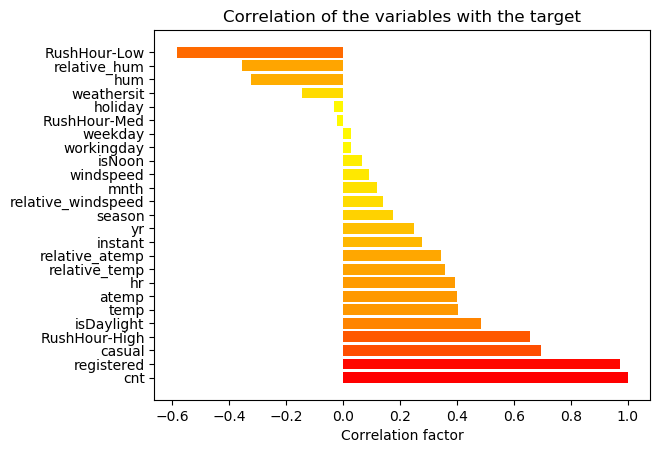

In [104]:
hey = hourly_raw_data.corr()['cnt'][:]
plt.rcdefaults()
fig, ax = plt.subplots()

import matplotlib.colors as mcolors
# Example data
people = hey.sort_values().index
y_pos = np.arange(len(people))
performance = hey.sort_values()

cmap = mcolors.LinearSegmentedColormap.from_list("", ["yellow", "red"])

ax.barh(y_pos, performance,  align='center', color=cmap(np.abs(performance)))
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Correlation factor')
ax.set_title('Correlation of the variables with the target')

plt.show()